In [1]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import json
import glob
import time
from PIL import Image

In [2]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

In [3]:
class MLP(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.linear = nn.Linear(dense_size, 1)
        self.linear.apply(self._init_weights)
        
    def _init_weights(self, module):
        torch.nn.init.kaiming_normal_(module.weight.data, nonlinearity="relu")
    
    def forward(self, last_hidden_states, input_ids, attention_mask):
        batch_size = last_hidden_states.shape[0]
        tok_weights = torch.log1p(torch.relu(self.linear(last_hidden_states))).squeeze(-1)*attention_mask
        lex_weights = torch.zeros(batch_size, self.vocab_size).to(device)
        columns = torch.arange(batch_size).repeat((77,1)).T
        lex_weights[columns, input_ids.type(torch.int64)] = tok_weights
        return lex_weights

In [4]:
class MLM(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dense_size, vocab_size)
        
    def forward(self, dense_vec):
        term_importances = torch.log1p(torch.relu(self.linear(dense_vec)))
        return term_importances

In [5]:
def test_sparse_performance(MLP, MLM, CLIP, test_loader):
    with torch.no_grad():
        encoded_images = torch.Tensor()
        encoded_captions = torch.Tensor()
        for batch in test_loader:
            ims, tokenized_caps = batch
            # encode images
            ims = model.vision_model(ims.to(device)).pooler_output
            ims = model.visual_projection(ims)
            encoded_ims = image_encoder(ims)
            # encode captions
            batch_length = tokenized_caps['input_ids'].shape[0]
            tokenized_caps['input_ids'] = tokenized_caps['input_ids'].reshape(batch_length*5, 77)
            tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].reshape(batch_length*5, 77)
            last_hidden_states = model.text_model(**tokenized_caps).last_hidden_state
            last_hidden_states = model.text_projection(last_hidden_states)
            input_ids = tokenized_caps['input_ids']
            attention_masks = tokenized_caps['attention_mask']
            encoded_caps = text_encoder(last_hidden_states, input_ids, attention_masks)
            # normalize
            encoded_ims = encoded_ims / encoded_ims.norm(dim=-1, keepdim=True)
            encoded_caps = encoded_caps / (encoded_caps + 1e-20).norm(dim=-1, keepdim=True)
            
            encoded_images = torch.cat((encoded_images, encoded_ims.to("cpu")), 0)
            encoded_captions = torch.cat((encoded_captions, encoded_caps.to("cpu")), 0)
        
        recall_1 = []
        recall_5 = []
        recall_10 = []
        encoded_images = encoded_images.to(device)
        i = 0
        image_id = 0
        for text_feature in encoded_captions:
            similarity = (100.0 * text_feature.to(device) @ encoded_images.T).softmax(dim=-1)

            values, indices = similarity.topk(1)
            recall_1.append(image_id in indices)

            values, indices = similarity.topk(5)
            recall_5.append(image_id in indices)

            values, indices = similarity.topk(10)
            recall_10.append(image_id in indices)

            i += 1
            if i == 5:
                i = 0
                image_id += 1

        recall_1 = torch.Tensor(recall_1)
        recall_5 = torch.Tensor(recall_5)
        recall_10 = torch.Tensor(recall_10)
        return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [6]:
def test_CLIP_performance(CLIP, test_loader):
    with torch.no_grad():
        encoded_images = torch.Tensor()
        encoded_captions = torch.Tensor()
        for batch in test_loader:
            ims, tokenized_caps = batch
            # encode images
            ims = model.vision_model(ims.to(device)).pooler_output
            ims = model.visual_projection(ims)
            # encode captions
            batch_length = tokenized_caps['input_ids'].shape[0]
            tokenized_caps['input_ids'] = tokenized_caps['input_ids'].reshape(batch_length*5, 77)
            tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].reshape(batch_length*5, 77)
            pooler_output = model.text_model(**tokenized_caps).pooler_output
            pooler_output = model.text_projection(pooler_output)
            
            # normalize
            ims = ims / ims.norm(dim=-1, keepdim=True)
            pooler_output = pooler_output / pooler_output.norm(dim=-1, keepdim=True)
            
            encoded_images = torch.cat((encoded_images, ims.to("cpu")), 0)
            encoded_captions = torch.cat((encoded_captions, pooler_output.to("cpu")), 0)
        
        recall_1 = []
        recall_5 = []
        recall_10 = []
        encoded_images = encoded_images.to(device)
        i = 0
        image_id = 0
        for text_feature in encoded_captions:
            similarity = (100.0 * text_feature.to(device) @ encoded_images.T).softmax(dim=-1)

            values, indices = similarity.topk(1)
            recall_1.append(image_id in indices)

            values, indices = similarity.topk(5)
            recall_5.append(image_id in indices)

            values, indices = similarity.topk(10)
            recall_10.append(image_id in indices)

            i += 1
            if i == 5:
                i = 0
                image_id += 1

        recall_1 = torch.Tensor(recall_1)
        recall_5 = torch.Tensor(recall_5)
        recall_10 = torch.Tensor(recall_10)
        return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [7]:
class TrainBatches():
    def __init__(self, image_vectors, captions):

        self.images = image_vectors
        self.captions  = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [8]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'

In [9]:
files = files[0:1000]
captions = captions[0:5000]

#test_files = test_files[0:100]
#test_captions = test_captions[0:500]

In [10]:
images = []
i = 0
with torch.no_grad():
    for filename in files:
        im = preprocess(Image.open(filename), return_tensors='pt')['pixel_values'].squeeze()
        for _ in range(5):
            images.append(im)
        i+=1
        if (i%100) == 0:
            print(i,"/",len(files), end='\r')
        
print("")
print("done")

1000 / 1000
done


In [11]:
# tokenize captions
L = len(captions)
t1 = time.time()
with torch.no_grad():
    tokenized_captions = []
    for i in range(0, L):
        if (i%1000) == 0:
            print(i,"/",L, end='\r')
        text = tokenizer(captions[i], padding='max_length', max_length=77, return_tensors='pt').to(device)
        tokenized_captions.append(text)
        
print("")
print("done")
print(time.time() - t1)

4000 / 5000
done
1.0879895687103271


In [12]:
test_images = []
i = 0
with torch.no_grad():
    for filename in test_files:
        im = preprocess(Image.open(filename), return_tensors='pt')['pixel_values'].squeeze()
        test_images.append(im)
        i+=1
        if (i%100) == 0:
            print(i,"/",len(test_files), end='\r')
        
print("")
print("done")

1000 / 1000
done


In [13]:
# tokenize captions
L = len(test_captions)
t1 = time.time()
with torch.no_grad():
    test_features = []
    for i in range(0, L, 5):
        if (i%1000) == 0:
            print(i,"/",L, end='\r')
        text = tokenizer(test_captions[i:i+5], padding='max_length', max_length=77, return_tensors='pt').to(device)
        test_features.append(text)
        
print("")
print("done")
print(time.time() - t1)

4000 / 5000
done
0.3860287666320801


In [14]:
batchsize = 64

test_dataset = TrainBatches(test_images, test_features)
test_dataloader = DataLoader(test_dataset, batch_size = batchsize, shuffle=True)

In [15]:
batchsize = 16

dataset = TrainBatches(images, tokenized_captions)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [16]:
dense_text_size = model.text_projection.weight.shape[0]
dense_image_size = model.visual_projection.weight.shape[0]
vocab_size = model.text_model.config.vocab_size

text_encoder = MLP(dense_text_size, vocab_size).to(device)
image_encoder = MLM(dense_image_size, vocab_size).to(device)

In [17]:
#before training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, model, test_dataloader)

print(rec1)
print(rec5)
print(rec10)

tensor(0.0004)
tensor(0.0028)
tensor(0.0070)


In [18]:
test_CLIP_performance(model, test_dataloader)

(tensor(0.5882), tensor(0.8344), tensor(0.9008))

In [44]:
a = torch.Tensor([[0,1,2], [1,1,1], [1,1,1], [1,1,1]])
b = torch.Tensor([[1,1,1], [1,1,1], [1,1,1], [0,1,2]])

In [46]:
torch.cdist(a,b.t())

RuntimeError: X1 and X2 must have the same number of columns. X1: 3 X2: 4

In [40]:
(a-b).pow(2).sum(1).sqrt()

tensor([1.4142, 0.0000, 0.0000, 0.0000])

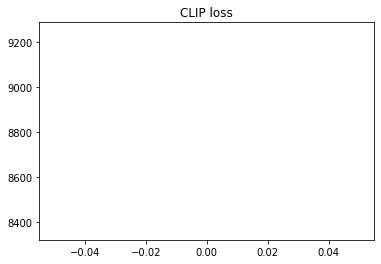

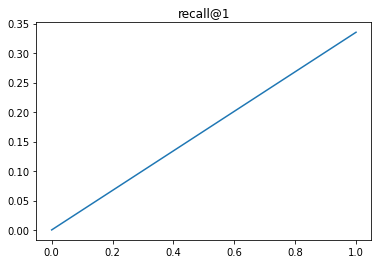

(tensor(0.6324), tensor(0.8722), tensor(0.9300))


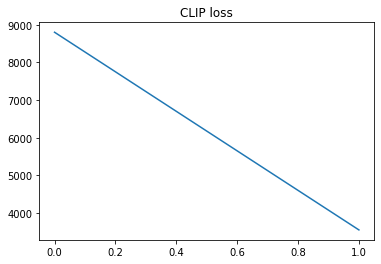

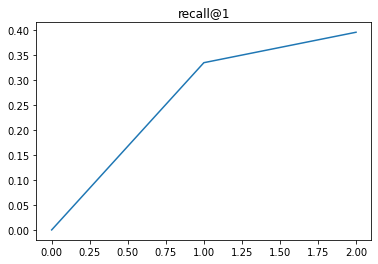

(tensor(0.6338), tensor(0.8754), tensor(0.9294))


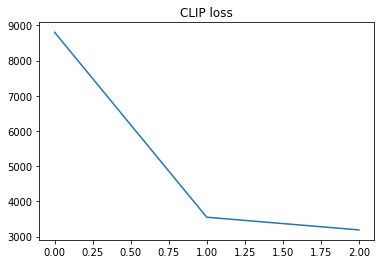

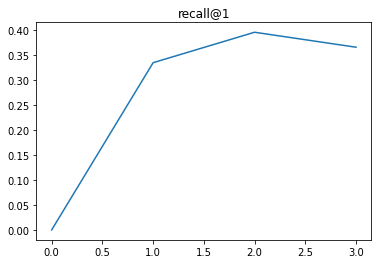

(tensor(0.6224), tensor(0.8630), tensor(0.9230))


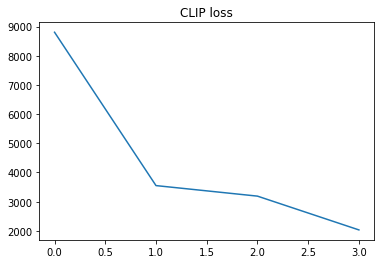

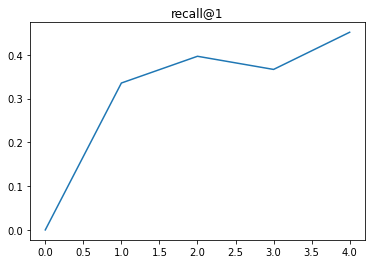

(tensor(0.6114), tensor(0.8518), tensor(0.9178))


KeyboardInterrupt: 

In [18]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
params = list(text_encoder.parameters()) + list(image_encoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
optimizer_clip = torch.optim.Adam(model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)

#optimizer_textclip = torch.optim.Adam(model.text_model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
#optimzer_visionclip = torch.optim.Adam(model.vision_model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.1)

vocab_size = model.text_model.config.vocab_size
epochs = 9
totalbatches = int(len(dataset) / batchsize)
logit_scale = model.logit_scale.exp().item()
losses=[]
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    batch_loss = 0
    for batch in train_dataloader:
        print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        optimizer_clip.zero_grad()
        ims, tokenized_caps = batch
        # encode images
        ims = model.vision_model(ims.to(device)).pooler_output
        ims = model.visual_projection(ims)
        sparse_ims = image_encoder(ims)

        # encode captions
        tokenized_caps['input_ids'] = tokenized_caps['input_ids'].squeeze()
        tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].squeeze()

        last_hidden_states = model.text_model(**tokenized_caps).last_hidden_state
        last_hidden_states = model.text_projection(last_hidden_states)
        input_ids = tokenized_caps['input_ids']
        attention_masks = tokenized_caps['attention_mask']

        sparse_caps = text_encoder(last_hidden_states, input_ids, attention_masks)
        
        # determine logits
        sparse_ims = sparse_ims / sparse_ims.norm(dim=-1, keepdim=True)
        sparse_caps = sparse_caps / (sparse_caps + 1e-20).norm(dim=-1, keepdim=True)
        logits_per_image = logit_scale * sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(ims),dtype=torch.long, device=device)
        loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        
        batch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        optimizer_clip.step()
        i+=1
        
    scheduler.step()
    losses.append(batch_loss)
    
    recall1,recall5,recall10 = test_sparse_performance(text_encoder, image_encoder, model, test_dataloader)
    test_loss[0].append(recall1)
    test_loss[1].append(recall5)
    test_loss[2].append(recall10)
    
    plt.plot(losses)
    plt.title('CLIP loss')
    plt.show()
    
    plt.plot(test_loss[0])
    plt.title('recall@1')
    plt.show()
    
    print(test_CLIP_performance(model, test_dataloader))

"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

In [28]:
(a-b).pow(2).sum().sqrt()

tensor(1.4142)

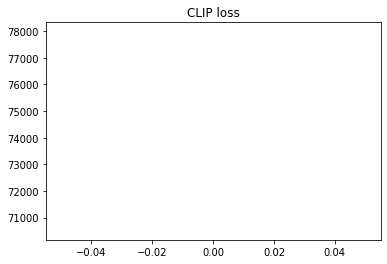

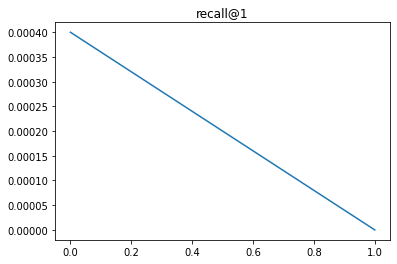

(tensor(0.5870), tensor(0.8306), tensor(0.8984))


KeyboardInterrupt: 

In [47]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
params = list(text_encoder.parameters()) + list(image_encoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
optimizer_clip = torch.optim.Adam(model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)

#optimizer_textclip = torch.optim.Adam(model.text_model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
#optimzer_visionclip = torch.optim.Adam(model.vision_model.parameters(), lr=1e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.1)

vocab_size = model.text_model.config.vocab_size
epochs = 9
totalbatches = int(len(dataset) / batchsize)
logit_scale = model.logit_scale.exp().item()
losses=[]
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    batch_loss = 0
    for batch in train_dataloader:
        print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        optimizer_clip.zero_grad()
        ims, tokenized_caps = batch
        # encode images
        ims = model.vision_model(ims.to(device)).pooler_output
        ims = model.visual_projection(ims)
        sparse_ims = image_encoder(ims)

        # encode captions
        tokenized_caps['input_ids'] = tokenized_caps['input_ids'].squeeze()
        tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].squeeze()

        last_hidden_states = model.text_model(**tokenized_caps).last_hidden_state
        last_hidden_states = model.text_projection(last_hidden_states)
        input_ids = tokenized_caps['input_ids']
        attention_masks = tokenized_caps['attention_mask']

        sparse_caps = text_encoder(last_hidden_states, input_ids, attention_masks)
        
        # determine logits
        logits_per_image = logit_scale * torch.cdist(sparse_ims, sparse_caps)
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(ims),dtype=torch.long, device=device)
        loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        
        batch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        optimizer_clip.step()
        i+=1
        
    scheduler.step()
    losses.append(batch_loss)
    
    recall1,recall5,recall10 = test_sparse_performance(text_encoder, image_encoder, model, test_dataloader)
    test_loss[0].append(recall1)
    test_loss[1].append(recall5)
    test_loss[2].append(recall10)
    
    plt.plot(losses)
    plt.title('CLIP loss')
    plt.show()
    
    plt.plot(test_loss[0])
    plt.title('recall@1')
    plt.show()
    
    print(test_CLIP_performance(model, test_dataloader))

"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

In [19]:
test_CLIP_performance(model, test_dataloader)

(tensor(0.5882), tensor(0.8344), tensor(0.9008))

In [20]:
losses

[9239.434705384076,
 3752.97773578763,
 3280.193608675152,
 2043.1577748793643,
 1455.841448839521,
 1231.7298746576998,
 930.8695133877045,
 802.0615859101235,
 715.2663214061758]

In [21]:
test_loss

[[tensor(0.0016),
  tensor(0.3374),
  tensor(0.3664),
  tensor(0.3818),
  tensor(0.4496),
  tensor(0.4590),
  tensor(0.4616),
  tensor(0.4736),
  tensor(0.4708),
  tensor(0.4698)],
 [tensor(0.0070),
  tensor(0.6274),
  tensor(0.6620),
  tensor(0.6742),
  tensor(0.7476),
  tensor(0.7582),
  tensor(0.7524),
  tensor(0.7602),
  tensor(0.7588),
  tensor(0.7598)],
 [tensor(0.0122),
  tensor(0.7378),
  tensor(0.7654),
  tensor(0.7706),
  tensor(0.8334),
  tensor(0.8380),
  tensor(0.8356),
  tensor(0.8442),
  tensor(0.8476),
  tensor(0.8456)]]

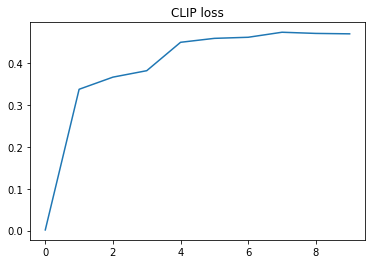

In [23]:
plt.plot(test_loss[0])
plt.title('CLIP loss')
plt.show()

In [28]:
torch.save({
    'epoch':epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, f"Models/" + "model" + ".pt")

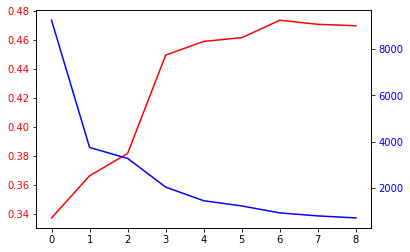

In [22]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][1:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()

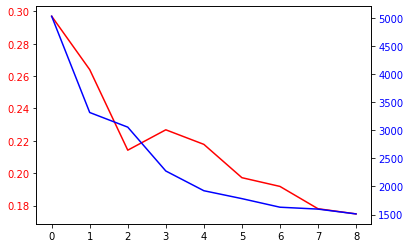

In [20]:
# forgot zero_grad
fig, ax = plt.subplots()

ax.plot(test_loss[0][1:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()

In [ ]:
torch.save({
    'epoch':epoch,
    'model_state_dict': text_encoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, f"Models/" + "text_encoder" + ".pt")

In [ ]:
torch.save({
    'epoch':epoch,
    'model_state_dict': image_encoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, f"Models/" + "image_encoder" + ".pt")

In [ ]:
torch.save({
    'epoch':epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_CLIP.state_dict(),
    'loss': loss,
    }, f"Models/" + "model" + ".pt")

In [ ]:
sparse_encoding = image_encoder(test_images[0])

In [ ]:
plt.hist(sparse_encoding.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(sparse_encoding, 1)
print(l1_regularization)

In [85]:
torch.topk(sparse_encoding, 20).indices[0:20]

tensor([ 3801,  1375, 49406,  6116,   786,  2149, 12906,  4287,  3938, 11869,
        11692,  1121, 13293,  9812,   900, 12123, 11444,  2568,  3889,  2801],
       device='cuda:0')

In [20]:
sparse_encoding.unique(return_counts=True)

(tensor([0.0000e+00, 9.6690e-43, 6.2358e-42,  ..., 6.0891e-01, 6.7876e-01,
         8.8476e-01], device='cuda:0', grad_fn=<Unique2Backward0>),
 tensor([47638,     1,     1,  ...,     1,     1,     1], device='cuda:0'))

In [21]:
(sparse_encoding > 0.3).unique(return_counts=True)

(tensor([False,  True], device='cuda:0'),
 tensor([49370,    38], device='cuda:0'))

In [53]:
test_files[0]

'datasets/flickr30k/test/1007129816.jpg'

In [ ]:
#test set:

In [26]:
#after training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)

print(rec1)
print(rec5)
print(rec10)

tensor(0.4914)
tensor(0.7606)
tensor(0.8418)
